## Exercise: Exact Diagonalization

In [16]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh 
from itertools import product
import math
import scipy as sp
from tqdm import tqdm


In [2]:
#Function that with the constrains of N and L fixed builds the Fock basis
def fock_basis(N : int, L : int) -> np.ndarray : 
    """Generates the Fock basis

    Args: 
        N: number of atoms (int)
        L : total angular momentum (int)
        
    Return:
        basis (array): Elements of the Fock basis
    """
    basis = []
    for element in product(range(N + 1), repeat =  L + 1):
        if sum(element) == N: 
            if sum(l * n for l, n in enumerate(element)) == L:
                basis.append(element)
    
    return np.array(basis)

#Example of a basis for a given N and l
N = 3
L = 6
basis = fock_basis(N , L )
print('basis for N =', N, 'L =', L, ':', basis )
print('Number of elements in the basis: ', len(basis))

basis for N = 3 L = 6 : [[0 0 3 0 0 0 0]
 [0 1 1 1 0 0 0]
 [0 2 0 0 1 0 0]
 [1 0 0 2 0 0 0]
 [1 0 1 0 1 0 0]
 [1 1 0 0 0 1 0]
 [2 0 0 0 0 0 1]]
Number of elements in the basis:  7


In [3]:
#Useful functions to calculate the Hamiltonian 
def h_single_particle(L : int, adim_freq: float) -> float:
    ''' Calculates the diagonal single particle eigenergies for a given L

    Args:
        L: angular momentum of the state
        adim_freq: adimensional parameter representing (Ω/w)

    Return:
        float: single particle eniegenergies for a given angular momentum L.
    '''
    
    return 1 + L*(1 - adim_freq)

def integral(k : int, l: int, p: int, q: int) -> float:
    '''Calculates the integral of the interaction part matrix element

    Args:
        k, l, p, q: angular momentum number

    Return:
        float: value of the integral
    '''

    if k + l != p + q:
        return 0
    else:
        sqrt = np.sqrt(math.factorial(k)*math.factorial(l)*math.factorial(p)*math.factorial(q))
        return (math.factorial(k + l))/(2 * math.pi * sqrt * 2**(k + l))
        


In [4]:
#Function to built the full Hamiltonian matrix

def Hamiltonian (N: int, L : int, g_2D: float) -> np.ndarray:
    ''' Function that builts the full hamiltonian

    Args: 
        N: Number of atoms
        L: total angular momentum
        g_2D: adimensional control parameter

    Return:
        np.ndarray containing the Hamiltonian of the system
    '''

    #First we generate the basis
    basis = fock_basis(N, L)
    basis_elements = len(basis)

    #Initialize to zero the Hamiltonian
    H = np.zeros((basis_elements, basis_elements), dtype = complex)

    for i, state_i in enumerate(basis):
        for j, state_j in enumerate(basis):
            # Diagonal elements: single-particle energy
            if i == j:
                H[i, j] = sum(element*h_single_particle(k, adim_freq) for k, element in enumerate(state_i))

            #Two-Body part of the Hamiltonian
            two_body = 0
            for k in range(len(state_i)):
                for l in range(len(state_i)):
                    for p in range(len(state_i)):
                        for q in range(len(state_i)):
                            prefactor = 1
                            if state_j[q] > 0 and state_j[p] > 0: # Annihilation conditions
                                new_state = state_j.copy()
                                prefactor *= np.sqrt(new_state[q])
                                new_state[q] -= 1
                                prefactor*= np.sqrt(new_state[p])
                                new_state[p] -= 1
                                if new_state[l] < N and new_state[k] < N:  # Creation conditions
                                    prefactor *= np.sqrt(new_state[l] + 1)
                                    new_state[l] += 1
                                    prefactor *= np.sqrt(new_state[k] + 1)
                                    new_state[k] += 1
                                    if np.array_equal(new_state, state_i):
                                         #Takes into account the prefactos of the bosonic operators acting on a state
                                        two_body += (
                                            g_2D / 2 * prefactor * integral(k, l, p, q)
                                        )
            H[i, j] += two_body
    return H

#Example of the full Hamiltonian matrix for a given N and L and some parameters
N = 3
L = 5
adim_freq = 0.5
g_2D = 0.5
Hamiltonian (N, L, g_2D)

array([[5.64920776+0.j, 0.04873105+0.j, 0.04873105+0.j, 0.01722903+0.j,
        0.        +0.j],
       [0.04873105+0.j, 5.61936621+0.j, 0.03978874+0.j, 0.02813488+0.j,
        0.        +0.j],
       [0.04873105+0.j, 0.03978874+0.j, 5.60941902+0.j, 0.03516861+0.j,
        0.02224258+0.j],
       [0.01722903+0.j, 0.02813488+0.j, 0.03516861+0.j, 5.61439262+0.j,
        0.01572788+0.j],
       [0.        +0.j, 0.        +0.j, 0.02224258+0.j, 0.01572788+0.j,
        5.58952466+0.j]])

In [5]:
#Eigenvalues and eigenvectors of the Hamiltonian for L = 0 to L = 6 for some parameters conditions
N = 3
L = 6
adim_freq = 0.5
g_2D = 0.5
for L in range(0, L + 1 ):
    H = Hamiltonian (N, L, g_2D)
    eigenvalues, eigenvectors = np.linalg.eig(H)
    print('Eigenvalues for L = ', L,':' , eigenvalues)
    print('Eigenvectors for L =', L, ':', eigenvectors)

Eigenvalues for L =  0 : [3.23873241+0.j]
Eigenvectors for L = 0 : [[1.+0.j]]
Eigenvalues for L =  1 : [3.73873241+0.j]
Eigenvectors for L = 1 : [[1.+0.j]]
Eigenvalues for L =  2 : [4.23873241+0.j 4.11936621+0.j]
Eigenvectors for L = 2 : [[ 0.81649658+0.j -0.57735027+0.j]
 [ 0.57735027-0.j  0.81649658+0.j]]
Eigenvalues for L =  3 : [4.73873241+0.j 4.5596831 +0.j 4.61936621+0.j]
Eigenvectors for L = 3 : [[ 4.71404521e-01-0.j  6.66666667e-01+0.j -5.77350269e-01+0.j]
 [ 8.16496581e-01+0.j -5.77350269e-01+0.j -1.79335251e-14+0.j]
 [ 3.33333333e-01-0.j  4.71404521e-01-0.j  8.16496581e-01+0.j]]
Eigenvalues for L =  4 : [5.23873241+0.j 5.11936621+0.j 5.0596831 +0.j 5.08952466+0.j]
Eigenvectors for L = 4 : [[ 6.66666667e-01+0.j -5.77350269e-01+0.j -4.71404521e-01+0.j
   1.91429847e-14-0.j]
 [ 4.71404521e-01-0.j  3.51105124e-15-0.j  6.66666667e-01+0.j
  -5.77350269e-01+0.j]
 [ 5.44331054e-01-0.j  4.71404521e-01-0.j  1.92450090e-01+0.j
   6.66666667e-01+0.j]
 [ 1.92450090e-01-0.j  6.66666667e-01

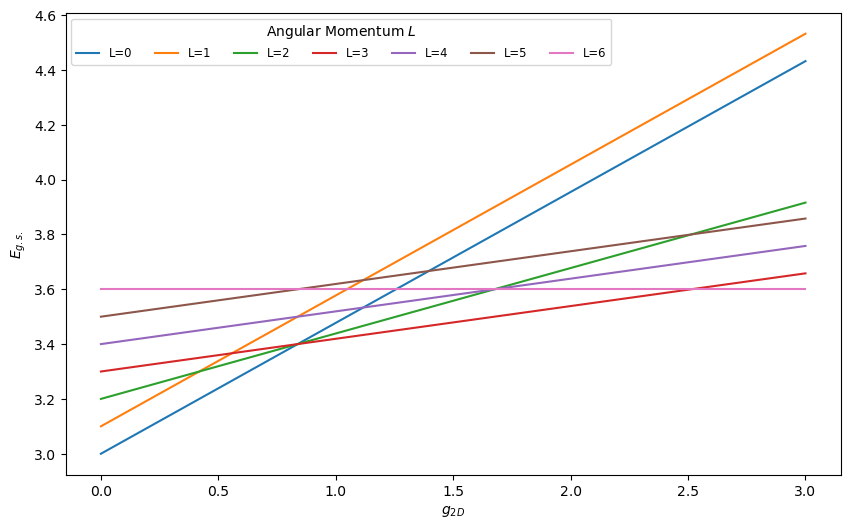

In [7]:
## Plots of the ground state energy for different g
N = 3
L_max = 6
adim_freq = 0.9
g_2D_values = np.linspace(0, 3, 100) 

# Initilize list to store the g.s. energy for every L and g_2D 
ground_state_energies = {L: [] for L in range(L_max + 1)}

#Eigenvalues calculation
for L in range(0, L_max + 1):
    for g_2D in g_2D_values:
        H = Hamiltonian(N, L, g_2D)  
        eigenvalues, _ = np.linalg.eig(H)
        ground_state_energies[L].append(np.min(eigenvalues))  

# Plot
plt.figure(figsize=(10, 6))

for L, ground_state in ground_state_energies.items():
    plt.plot(g_2D_values, ground_state, label=f"L={L}")

plt.xlabel('$g_{2D}$')
plt.ylabel('$E_{g.s.}$')
plt.legend(
    title="Angular Momentum $L$",
    loc='upper left',
    #bbox_to_anchor=(0.5, 0.1),  # Posición fuera del gráfico
    ncol=L_max + 1,  # Una columna por cada valor de L
    fontsize='small'
)
plt.show()


<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:27: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:27: SyntaxWarning: invalid escape sequence '\O'
C:\Users\glanc\AppData\Local\Temp\ipykernel_18316\718517032.py:20: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(L_values, energies, linestyle='None', marker='_', markersize=10, label=f'$\Omega/\omega$ = {adim_freq:.2f}')
C:\Users\glanc\AppData\Local\Temp\ipykernel_18316\718517032.py:27: SyntaxWarning: invalid escape sequence '\O'
  plt.legend(title='$\Omega/\omega$')


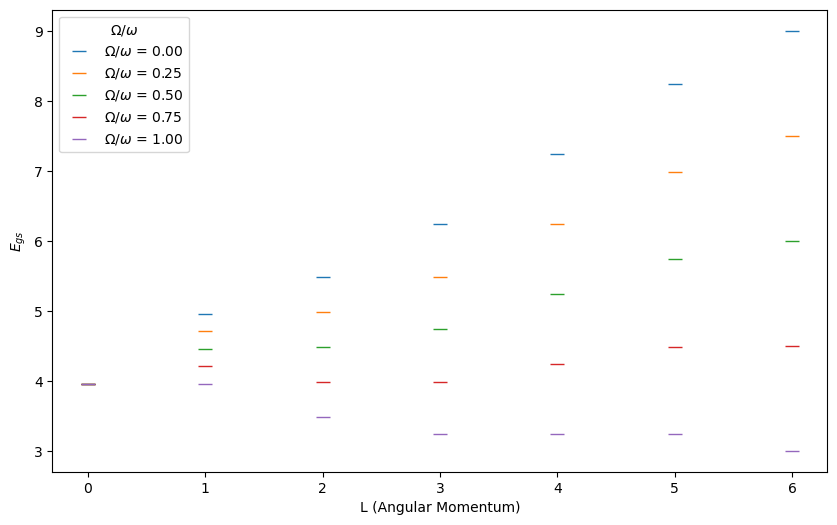

In [8]:
# Parameters
N = 3
L_max = 6
g_2D = 2
adim_freq_values = np.linspace(0, 1, 5)  # 5 values of adim_freq from 0 to 1
L_values = range(L_max + 1)

# Calculate ground state energy for each L and adim_freq
ground_state_energies = {adim_freq: [] for adim_freq in adim_freq_values}

for adim_freq in adim_freq_values:
    for L in L_values:
        H = Hamiltonian(N, L, g_2D)
        eigenvalues, _ = np.linalg.eig(H)
        ground_state_energies[adim_freq].append(np.min(eigenvalues.real))  # Ground state energy

# Plotting
plt.figure(figsize=(10, 6))
for adim_freq, energies in ground_state_energies.items():
    plt.plot(L_values, energies, linestyle='None', marker='_', markersize=10, label=f'$\Omega/\omega$ = {adim_freq:.2f}')  
    


plt.xlabel('L (Angular Momentum)')
plt.ylabel('$E_{gs}$')
plt.xticks(L_values)  # Ensure discrete ticks for L
plt.legend(title='$\Omega/\omega$')
plt.show()



In [9]:
#%% Eigenvalues and eigenvectors of the Hamiltonian for L = 0 to L = 6 for some parameters conditions
N = 3
L = 6
adim_freq = 0.5
g_2D = 0.5
eigenvalues = np.empty((L+1,7))
eigenvectors = np.empty((L+1,7,7))
eigenvalues[:,:] = 0
eigenvectors[:,:,:] = 0
eigenvalues[0,:1], eigenvectors[0,:1,:1] = np.linalg.eig(Hamiltonian(N,0,g_2D))

for l in range(1, L):
    H = Hamiltonian (N, l, g_2D)
    eigenvalues[l,:l], eigenvectors[l,:l,:l] = np.linalg.eigh(H)
    print(l)
    #print('Eigenvalues for L = ', l,':' , eigenvalues)
    #print('Eigenvectors for L =', l, ':', eigenvectors)
    
eigenvalues[L,:L+1], eigenvectors[L,:L+1,:L+1] = np.linalg.eig(Hamiltonian(N,L,g_2D))

C:\Users\glanc\AppData\Local\Temp\ipykernel_18316\2163162760.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[0,:1], eigenvectors[0,:1,:1] = np.linalg.eig(Hamiltonian(N,0,g_2D))
C:\Users\glanc\AppData\Local\Temp\ipykernel_18316\2163162760.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[l,:l], eigenvectors[l,:l,:l] = np.linalg.eigh(H)


1
2
3
4
5


C:\Users\glanc\AppData\Local\Temp\ipykernel_18316\2163162760.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[L,:L+1], eigenvectors[L,:L+1,:L+1] = np.linalg.eig(Hamiltonian(N,L,g_2D))


In [10]:
def density(eigenvector, N, L,z):
    rho = 0
    basis = fock_basis(N, L)
    for i in range(L+1):
        for j in range(L+1):
            for k in range(len(eigenvector)):
                new_state1 = basis[k].copy()
                new_state1[j] -= 1
                for l in range(len(eigenvector)):
                    new_state2 = basis[l].copy()
                    new_state2[i] -= 1
                    if np.multiply((new_state2 - new_state1),(new_state2 - new_state1)).sum() != 0 or np.any(new_state1 == -1):
                        continue
                    else:
                        rho +=np.sqrt(basis[l,i]*basis[k,j])*eigenvector[k]*np.conjugate(eigenvector[l])*z**j*np.exp(-np.abs(z)**2/2)/np.sqrt(np.pi*sp.special.factorial(j))*np.conjugate(z**i*np.exp(-np.abs(z)**2/2)/np.sqrt(np.pi*sp.special.factorial(i))) 
    return rho         

In [11]:
z = np.arange(-4,4,0.1)
rho = np.empty((L+1,len(z)))
N = 3
for l in range(0,L+1):
    for i in range(len(z)):
        k = len(fock_basis(N, l))
        rho[l,i] = density(eigenvectors[l,:k,0],N,l,z[i])

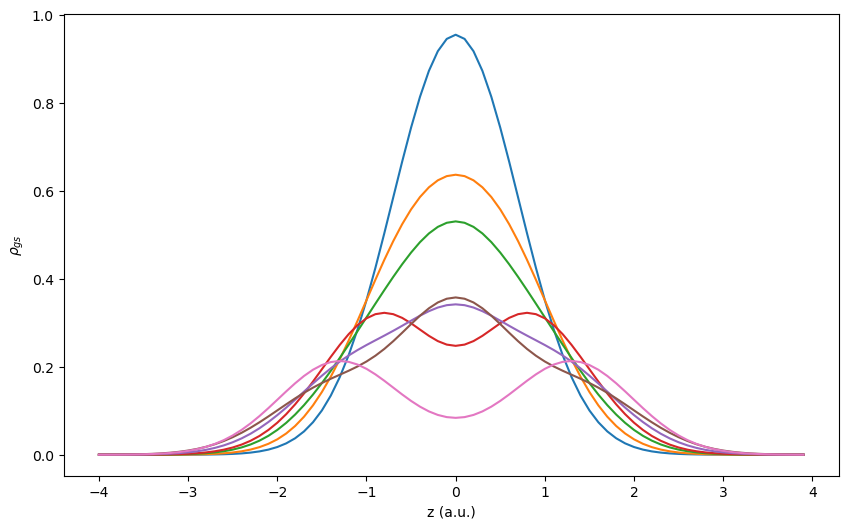

In [23]:
plt.figure(figsize=(10, 6))
plt.xlabel('z (a.u.)')
plt.ylabel(r'$\rho_{gs}$')
plt.plot(z,rho[0,:])
plt.plot(z,rho[1,:])
plt.plot(z,rho[2,:])
plt.plot(z,rho[3,:])
plt.plot(z,rho[4,:])
plt.plot(z,rho[5,:])
plt.plot(z,rho[6,:])

In [18]:
z_max = np.empty(L+1)

for i in range(L+1):
    idx = np.argmax(rho[i,:])
    z_max[i] = z[idx]

In [19]:
#%% Pair correlation operator 2nd quantization
def pair_corr(eigenvector, N, L,z1,z2):
    pair = 0
    basis = fock_basis(N, L)
    for i in range(L+1):
        for j in range(L+1):
            for k in range(L+1):
                for l in range(L+1):
                    for m in range(len(eigenvector)):
                        new_state1 = basis[m].copy()
                        new_state1[k] -= 1
                        new_state1[l] -= 1
                        for n in range(len(eigenvector)):
                            new_state2 = basis[n].copy()
                            new_state2[i] -= 1
                            new_state2[j] -= 1
                            if np.multiply((new_state2 - new_state1),(new_state2 - new_state1)).sum() == 0:
                                pair +=np.sqrt(basis[m,k]*(new_state1[l]+1)*basis[n,i]*(new_state2[j]+1))*eigenvector[m]*np.conjugate(eigenvector[n])*np.conjugate(z1**i*np.exp(-np.abs(z1)**2/2)/np.sqrt(np.pi*math.factorial(i))*z2**j*np.exp(-np.abs(z2)**2/2)/np.sqrt(np.pi*math.factorial(j)))*z1**k*np.exp(-np.abs(z1)**2/2)/np.sqrt(np.pi*math.factorial(k))*z2**l*np.exp(-np.abs(z2)**2/2)/np.sqrt(np.pi*math.factorial(l)) 

      
    return pair   

In [20]:
z = np.arange(-4,4,0.1)
pair = np.empty((L+1,len(z)))
N = 3
for l in tqdm(range(0,L+1)):
    for i in range(len(z)):
        k = len(fock_basis(N, l))
        pair[l,i] = pair_corr(eigenvectors[l,:k,0],N,l,z[i],z_max[l])

100%|██████████| 7/7 [01:02<00:00,  8.92s/it]


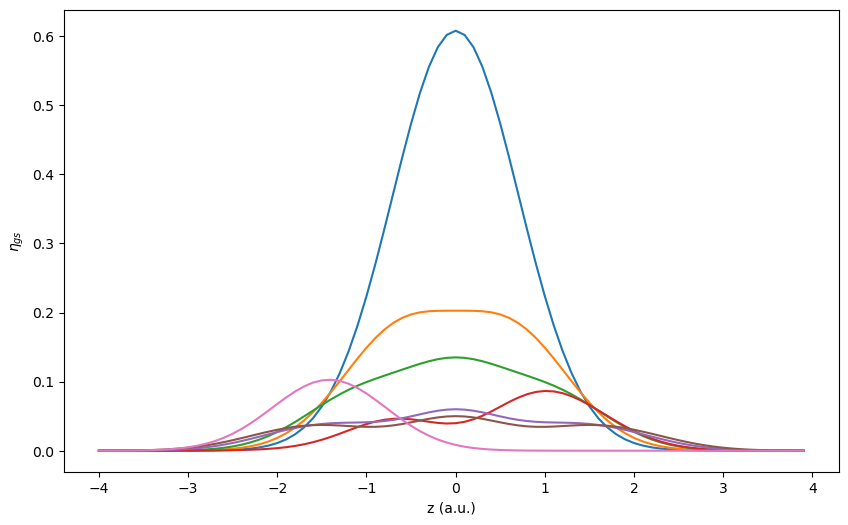

In [24]:
plt.figure(figsize=(10, 6))
plt.xlabel('z (a.u.)')
plt.ylabel(r'$\eta_{gs}$')
plt.plot(z,pair[0,:])
plt.plot(z,pair[1,:])
plt.plot(z,pair[2,:])
plt.plot(z,pair[3,:])
plt.plot(z,pair[4,:])
plt.plot(z,pair[5,:])
plt.plot(z,pair[6,:])